# Domaci zadatak 3 - Neuronske mreže

<b>Studenti: Vladan Milojević - 1248, Vladimir Nešić - 1235</b>

Cilj projekta je predviđanje smrtnog ishoda kod pacijenata koji su doživeli zastoj srca. Dataset koji se koristi: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

Da bi dataset bio balansiran, generisani su podaci uz pomoc SMOTE filtera u Weka programu.

### Korišćene biblioteke, učitavanje i analiza podataka

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, plot_roc_curve
import matplotlib.pyplot as plt  
import tensorflow as tf
from tensorflow import keras
from keras.layers import Bidirectional, Dense, Dropout
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.python.keras.callbacks import TensorBoard
from keras_visualizer import visualizer 
from time import time
import keras.backend as K

In [66]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [67]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [68]:
data.isnull().any()

age                         False
anaemia                     False
creatinine_phosphokinase    False
diabetes                    False
ejection_fraction           False
high_blood_pressure         False
platelets                   False
serum_creatinine            False
serum_sodium                False
sex                         False
smoking                     False
time                        False
DEATH_EVENT                 False
dtype: bool

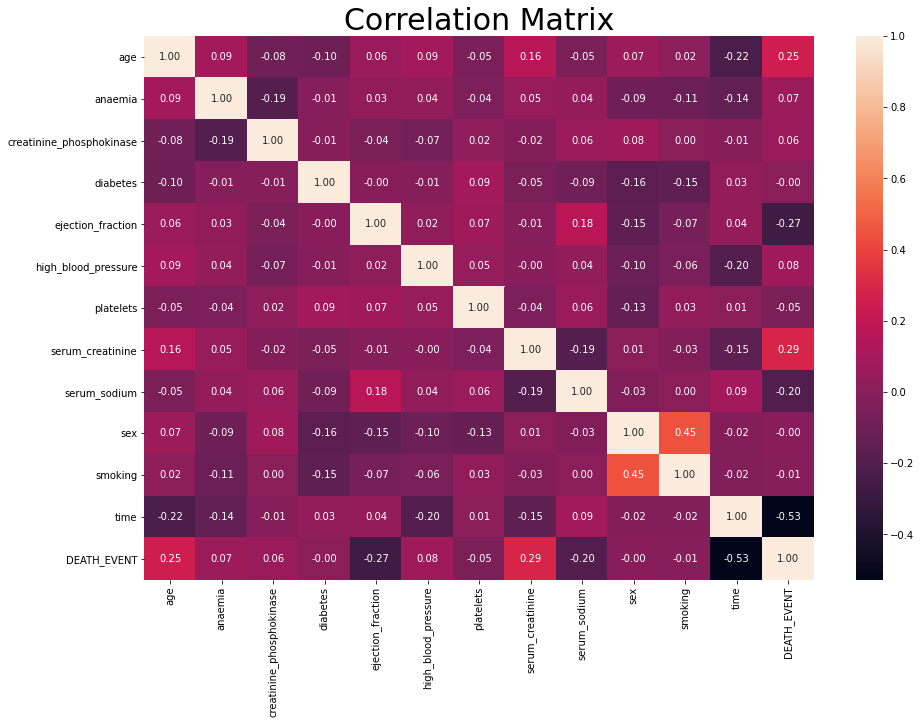

In [69]:
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_mat,annot=True,fmt='.2f')
plt.title("Correlation Matrix",fontsize=30)
plt.show()

### Balansiranost klasnog atributa

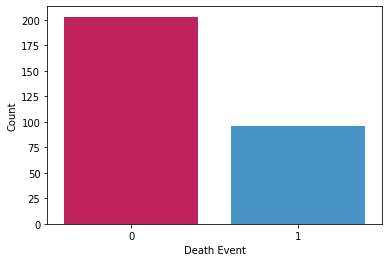

In [70]:
sns.countplot(x="DEATH_EVENT",data=data,palette=["#DA0858","#3498DB"])
plt.ylabel("Count")
plt.xlabel("Death Event")
plt.show()

Kako bi klasni atribut bio balansiran, upotrebljen je SMOTE filter.

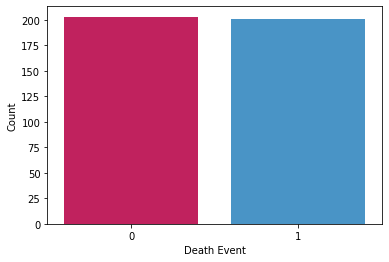

In [71]:
#loading balanced data
data = pd.read_csv("heart_failure_clinical_records_dataset_balanced.csv")

sns.countplot(x="DEATH_EVENT",data=data,palette=["#DA0858","#3498DB"])
plt.ylabel("Count")
plt.xlabel("Death Event")
plt.show()

### Priprema podataka

In [72]:
feature_data = data.drop(["DEATH_EVENT"],axis=1)
class_data = data["DEATH_EVENT"]
class_data = class_data.astype('float')

col_names = list(feature_data.columns)
s_scaler = preprocessing.StandardScaler()
feature_data = s_scaler.fit_transform(feature_data)
feature_data = pd.DataFrame(feature_data, columns=col_names)

### Train model and print metrics

In [73]:
def train_model_and_print_metrics(model, X_train, X_test, y_train, y_test):
    history = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_split=0.2)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    test_loss, test_acc = model.evaluate(X_test, y_test)
    target_names = ['0', '1']

    print(classification_report(y_test, y_pred, target_names=target_names))

    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    print('Test loss: ', test_loss)
    print('Test accuracy: ', test_acc)

### Custom Loss funkcije

In [74]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

### Kreiranje i treniranje modela

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 9)                 117       
_________________________________________________________________
dense_57 (Dense)             (None, 7)                 70        
_________________________________________________________________
dense_58 (Dense)             (None, 5)                 40        
_________________________________________________________________
dropout_13 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 6         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
8/8 [==============================] - 1s 30ms/step - loss: 0.4890 - accuracy: 0.5285 - val_loss: 0.4854

8/8 [==============================] - 0s 9ms/step - loss: 0.3098 - accuracy: 0.7603 - val_loss: 0.2931 - val_accuracy: 0.8070
Epoch 53/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2961 - accuracy: 0.7804 - val_loss: 0.2900 - val_accuracy: 0.8246
Epoch 54/100
8/8 [==============================] - 0s 9ms/step - loss: 0.2788 - accuracy: 0.7896 - val_loss: 0.2868 - val_accuracy: 0.8246
Epoch 55/100
8/8 [==============================] - 0s 9ms/step - loss: 0.2842 - accuracy: 0.8153 - val_loss: 0.2828 - val_accuracy: 0.8421
Epoch 56/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2786 - accuracy: 0.7943 - val_loss: 0.2791 - val_accuracy: 0.8596
Epoch 57/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2868 - accuracy: 0.8149 - val_loss: 0.2752 - val_accuracy: 0.8596
Epoch 58/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2738 - accuracy: 0.7877 - val_loss: 0.2722 - val_accuracy: 0.8596
Epoch 59/100
8/8 [===========

c:\users\doubl\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\doubl\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\doubl\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

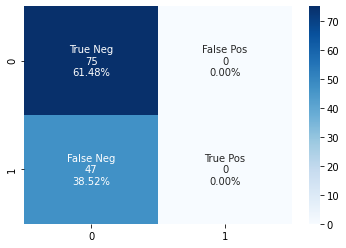

In [75]:
model = Sequential()

model.add(Dense(units = 9, activation = 'relu', input_dim = 12))
# model.add(Dropout(0.1))
model.add(Dense(units = 7, activation = 'relu'))
model.add(Dense(units = 5, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation = 'sigmoid'))

print(model.summary())

model.compile(optimizer = 'adam', loss = euclidean_distance_loss, metrics = ['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(feature_data,class_data,test_size=0.3,random_state=0)

train_model_and_print_metrics(model, X_train, X_test, y_train, y_test)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 7)                 91        
_________________________________________________________________
dropout_14 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_62 (Dense)             (None, 3)                 15        
_________________________________________________________________
dropout_15 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 4         
Total params: 142
Trainable params: 142
Non-trainable params: 0
_______________________________________________________

8/8 [==============================] - 0s 8ms/step - loss: 0.6182 - accuracy: 0.7717 - val_loss: 0.5884 - val_accuracy: 0.8246
Epoch 52/100
8/8 [==============================] - 0s 12ms/step - loss: 0.6141 - accuracy: 0.7995 - val_loss: 0.5831 - val_accuracy: 0.8246
Epoch 53/100
8/8 [==============================] - 0s 10ms/step - loss: 0.6027 - accuracy: 0.8145 - val_loss: 0.5778 - val_accuracy: 0.8596
Epoch 54/100
8/8 [==============================] - 0s 8ms/step - loss: 0.5999 - accuracy: 0.8056 - val_loss: 0.5733 - val_accuracy: 0.8596
Epoch 55/100
8/8 [==============================] - 0s 10ms/step - loss: 0.6182 - accuracy: 0.7653 - val_loss: 0.5662 - val_accuracy: 0.8772
Epoch 56/100
8/8 [==============================] - 0s 25ms/step - loss: 0.6128 - accuracy: 0.7281 - val_loss: 0.5597 - val_accuracy: 0.8596
Epoch 57/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5788 - accuracy: 0.8115 - val_loss: 0.5528 - val_accuracy: 0.8596
Epoch 58/100
8/8 [===========

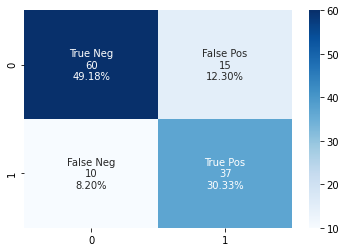

In [76]:
model = Sequential()

model.add(Dense(units = 7, activation = 'relu', input_dim = 12))
model.add(Dropout(0.1))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 3, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation = 'sigmoid'))

print(model.summary())

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(feature_data,class_data,test_size=0.3,random_state=0)

train_model_and_print_metrics(model, X_train, X_test, y_train, y_test)

### Redukcija dimenzionalnosti pomoću PCA

In [77]:
pca = PCA(n_components=12, random_state=2020)
pca.fit(feature_data)
feature_data_pca = pca.transform(feature_data)

print(sum(pca.explained_variance_ratio_ * 100))

100.00000000000001


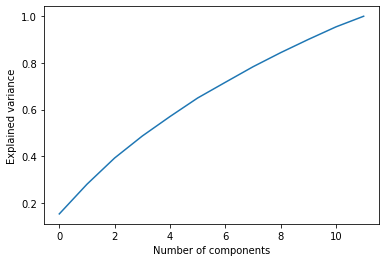

In [78]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

In [79]:
print(np.cumsum(pca.explained_variance_ratio_ * 100)[8])

84.38377031224752


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 7)                 70        
_________________________________________________________________
dense_65 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_66 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 4         
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
8/8 [==============================] - 1s 26ms/step - loss: 0.6998 - accuracy: 0.3752 - val_loss: 0.6881 - val_accuracy: 0.4211
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.7026 - accuracy: 0.4608 - val_loss:

8/8 [==============================] - 0s 9ms/step - loss: 0.6140 - accuracy: 0.7800 - val_loss: 0.5930 - val_accuracy: 0.8421
Epoch 54/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5990 - accuracy: 0.7961 - val_loss: 0.5866 - val_accuracy: 0.8246
Epoch 55/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5982 - accuracy: 0.7863 - val_loss: 0.5800 - val_accuracy: 0.8246
Epoch 56/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5932 - accuracy: 0.7662 - val_loss: 0.5744 - val_accuracy: 0.8070
Epoch 57/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5952 - accuracy: 0.7699 - val_loss: 0.5679 - val_accuracy: 0.7895
Epoch 58/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5993 - accuracy: 0.7587 - val_loss: 0.5625 - val_accuracy: 0.8070
Epoch 59/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5848 - accuracy: 0.8171 - val_loss: 0.5577 - val_accuracy: 0.8070
Epoch 60/100
8/8 [===============

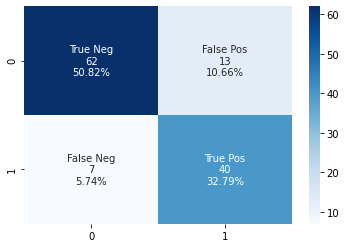

In [80]:
pca_9 = PCA(n_components=9, random_state=2020)
pca_9.fit(feature_data)
feature_data_pca_9 = pca_9.transform(feature_data)

X_train, X_test, y_train, y_test = train_test_split(feature_data_pca_9,class_data,test_size=0.3,random_state=0)

model_pca = Sequential()

model_pca.add(Dense(units = 7, activation = 'relu', input_dim = 9))
model_pca.add(Dense(units = 5, activation = 'relu'))
model_pca.add(Dense(units = 3, activation = 'relu'))
model_pca.add(Dense(units = 1, activation = 'sigmoid'))

print(model_pca.summary())

model_pca.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

train_model_and_print_metrics(model_pca, X_train, X_test, y_train, y_test)